In [87]:
import numpy as np
import torch

from torch import nn

PATH = "/home/sagarpatel/Desktop/ece496-capstone/"

In [88]:
from video import Video

video_path = PATH + "train/sample/video.mp4"
transcript_path = PATH + "train/sample/transcript.vtt"
transcript2_path = PATH + "train/sample/transcript2.vtt"

v = Video(video_path, transcript_path)
v.align()
v.generate_frames("sample", swap=True)

v2 = Video(video_path, transcript2_path)
v2.align()
v2.generate_frames("sample", swap=True)

In [89]:
import glob
import itertools

from loss import loss_RA_MIL
from detector import Detector
from parser import parse

detector = Detector()

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /home/sagarpatel/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


In [90]:
import importlib
import loss
importlib.reload(loss)

<module 'loss' from '/home/sagarpatel/Desktop/ece496-capstone/train/loss.py'>

In [91]:
images = sorted(glob.glob(PATH + "train/sample/*.png"))
candidates = [detector.inference(image, max_detections=5) for image in images]

In [92]:
NULL = '[unused1]'
PAD = '[unused2]'
ENTITY = '[unused3]'
ACTION = '[SEP]'

MAX_STEP_LENGTH = 30

In [93]:
steps1 = [step.text.strip() for step in v.steps]
steps2 = [step.text.strip() for step in v2.steps]

In [94]:
# from transformers import LxmertModel, LxmertTokenizer

# tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased", pad_token=PAD)
# tokenizer.add_special_tokens({"additional_special_tokens": [NULL, PAD, ENTITY]})
# tokenizer.encode([NULL, PAD, ENTITY], add_special_tokens=True)

# tokens_steps1 = tokenizer(
#                     steps1,
#                     return_token_type_ids=False,
#                     return_attention_mask=False,
#                     add_special_tokens=True,
#                     padding="max_length",
#                     max_length=MAX_STEP_LENGTH + 2,
#                     return_tensors="pt"
#                 )

# tokens_steps2 = tokenizer(
#                     steps2,
#                     return_token_type_ids=False,
#                     return_attention_mask=False,
#                     add_special_tokens=True,
#                     padding="max_length",
#                     max_length=MAX_STEP_LENGTH + 2,
#                     return_tensors="pt"
#                 )

In [95]:
steps2

['Grill [unused3] the tomatoes.',
 'Add [unused3] oil.',
 'Cook [unused3] the bacon.',
 'Spread [unused3] some mayonnaise.',
 'Place [unused3] a piece of [unused3] lettuce onto [unused3] it.',
 'Place [unused3] the tomatoes over [unused3] it.',
 'Sprinkle some pepper onto [unused3] it.',
 'Place [unused3] the bacon at [unused3] the top.',
 'Place the [unused3] piece of bread at the top.']

In [96]:
steps1

['Grill [unused3] the tomatoes in [unused3] a pan.',
 'Add [unused3] oil into [unused3] the pan.',
 'Cook [unused3] the bacon.',
 'Spread [unused3] some mayonnaise onto [unused3] the bread.',
 'Place [unused3] a piece of [unused3] lettuce onto [unused3] it.',
 'Place [unused3] the tomatoes over [unused3] it.',
 'Sprinkle [unused3] some salt and pepper onto [unused3] it.',
 'Place [unused3] the bacon at [unused3] the top.',
 'Place the [unused3] piece of bread at the top.']

In [97]:
steps1_flat = ' [SEP] '.join(steps1) + ' ' + NULL + ' [SEP]'
steps2_flat = ' [SEP] '.join(steps2) + ' ' + NULL + ' [SEP]'

In [98]:
steps1_flat

'Grill [unused3] the tomatoes in [unused3] a pan. [SEP] Add [unused3] oil into [unused3] the pan. [SEP] Cook [unused3] the bacon. [SEP] Spread [unused3] some mayonnaise onto [unused3] the bread. [SEP] Place [unused3] a piece of [unused3] lettuce onto [unused3] it. [SEP] Place [unused3] the tomatoes over [unused3] it. [SEP] Sprinkle [unused3] some salt and pepper onto [unused3] it. [SEP] Place [unused3] the bacon at [unused3] the top. [SEP] Place the [unused3] piece of bread at the top. [unused1] [SEP]'

In [99]:
# Find all of the bounding boxes for the detections and their features.
boxes = torch.tensor([candidate[0].numpy() for candidate in candidates]).squeeze(1)
features = torch.tensor([candidate[1].numpy() for candidate in candidates]).squeeze(1)

boxes = boxes.flatten(start_dim=0, end_dim=1)
features = features.flatten(start_dim=0, end_dim=1)

boxes = torch.stack((boxes, boxes))
features = torch.stack((features, features))

In [100]:
# https://github.com/google-research/bert/issues/635
# https://colab.research.google.com/drive/18TyuMfZYlgQ_nXo-tr8LCnzUaoX0KS-h?usp=sharing#scrollTo=W4cZIVrg82ua.

import itertools
import torch
import einops

from transformers import LxmertModel, LxmertTokenizer
from torch import nn
from torch.nn.utils.rnn import pad_sequence

class Model(nn.Module):
    NULL = '[unused1]'
    PAD = '[unused2]'
    ENTITY = '[unused3]'
    ACTION = '[SEP]'
    
    DETECTION_EMBEDDING_SIZE = 2048
    OUTPUT_EMBEDDING_SIZE = 768
        
    def __init__(self):
        super(Model, self).__init__()
        
        self.lxmert_tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")
        self.lxmert_tokenizer.add_special_tokens({"additional_special_tokens": [NULL, PAD, ENTITY]})
        self.lxmert_tokenizer.encode([NULL, PAD, ENTITY])
        
        self.NULL_TOKEN = self.lxmert_tokenizer.convert_tokens_to_ids(NULL)
        self.ENTITY_TOKEN = self.lxmert_tokenizer.convert_tokens_to_ids(ENTITY)
        self.ACTION_TOKEN = self.lxmert_tokenizer.convert_tokens_to_ids(ACTION)
        
        self.lxmert = LxmertModel.from_pretrained("unc-nlp/lxmert-base-uncased")
        
    def forward(self, MAX_INSTRUCTION_LENGTH, BATCH_SIZE, NUM_ACTIONS, CANDIDATES, steps, features, boxes, entity_count):
        '''
            MAX_INSTRUCTION_LENGTH
                : maximum number of words in a combined string of steps for a video,
                  this instruction string must contain the NULL step.
                  
                  ex. | E ... E . [SEP] [PAD] [PAD] | .... [SEP] [PAD] | NULL | 
                  
            steps
                : batched video steps of size (BATCH_SIZE, NUM_ACTIONS), list of lists,
                  each instructional video must have the same number of steps = NUM_ACTIONS.
                
                  ex. [['step 1.1', 'step 1.2'], ['step 2.1', 'step 2.2']]
                
            features
                : batched detection features of size (BATCH_SIZE, CANDIDATES * NUM_ACTIONS, 2048)
                
            boxes
                : batched bounding boxes of detection features of size (BATCH_SIZE, CANDIDATES * NUM_ACTIONS, 4)
                
            entity_count:
                : number of entities per action, size (BATCH_SIZE, NUM_ACTIONS), list of lists
        '''

        inputs = self.lxmert_tokenizer(
            steps,
            padding="max_length",
            max_length= MAX_INSTRUCTION_LENGTH + 2, # [CLS] and [SEP] token
            truncation=False,
            return_token_type_ids=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )

        output = self.lxmert(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask,
            visual_feats=features,
            visual_pos=boxes,
            token_type_ids=inputs.token_type_ids,
            return_dict=True,
            output_attentions=True
        )
        
        token_ids = inputs.input_ids
        
        entity_idx = ((token_ids == self.ENTITY_TOKEN) | (token_ids == self.NULL_TOKEN))
        action_idx = (token_ids == self.ACTION_TOKEN)
        
        entity_embeddings = output['language_output'][entity_idx]
        action_embeddings = output['language_output'][action_idx]
        vision_embeddings = output['vision_output']
        
        split_sizes = torch.tensor(entity_count).flatten().tolist()
        entities = entity_embeddings.split(split_sizes)
        
        E = pad_sequence(entities, batch_first=True)
        max_entities = E.shape[1]
        E = E.reshape(-1, NUM_ACTIONS, E.shape[1], E.shape[2])

        A = action_embeddings.reshape(BATCH_SIZE, NUM_ACTIONS, -1)
        V = vision_embeddings.reshape(BATCH_SIZE, NUM_ACTIONS, CANDIDATES, -1)
        
        # Calculate loss_E.
        loss_E = E
        
        # Calculate VG (VG_scores_index) and loss_V.
        VG_scores = torch.einsum('bacs, baes -> baec', V, E)
        VG_scores_max, VG_scores_index = VG_scores.max(dim=-1)

        V_flat = V.reshape(-1, self.OUTPUT_EMBEDDING_SIZE)

        VG_scores_index_flat = VG_scores_index.flatten()
        offsets = torch.arange(0, BATCH_SIZE * NUM_ACTIONS * CANDIDATES, CANDIDATES)
        offsets = offsets.repeat_interleave(max_entities)

        VG_scores_index_flat = VG_scores_index_flat + offsets

        loss_V = V_flat[VG_scores_index_flat, :].reshape(BATCH_SIZE, NUM_ACTIONS, max_entities, -1)
        
        # Calculate RR (RR_scores_index).
        #note: we write c here as number of actions as well
        #since we don't wish to sum over a 
        RR_scores = torch.einsum('baes, bcs -> baec', E, A)

        edge_mask = torch.ones(NUM_ACTIONS, NUM_ACTIONS).tril(diagonal=-1)
        edge_mask[-1, :] = 0
        edge_mask[:, -1] = 1
        edge_mask = einops.repeat(edge_mask, 'x y -> b x c y', b=BATCH_SIZE, c=max_entities)

        RR_scores_max, RR_scores_index = (RR_scores * edge_mask).max(dim=-1)
        
        # Calculate loss_R.
        loss_R = torch.ones((BATCH_SIZE, NUM_ACTIONS, NUM_ACTIONS))

        dim_1 = RR_scores_index.reshape(BATCH_SIZE, -1)
        dim_2 = torch.arange(NUM_ACTIONS).repeat_interleave(max_entities)
        dim_2 = einops.repeat(dim_2, 'd -> b d', b=BATCH_SIZE)

        loss_R[:, dim_1, dim_2] = 0.0
        
        #entity embeddings, selected visual grounding embeddings, adjacency list for
        #ref resolution
        return loss_E, loss_V, loss_R, VG_scores_index, RR_scores_index, A, E, V

In [101]:
steps = [steps1_flat, steps2_flat]

ENTITIES_COUNT = [
    [2, 2, 1, 2, 3, 2, 2, 2, 1, 1],
    [1, 1, 1, 1, 3, 2, 1, 2, 1, 1]
]

In [102]:
model = Model()
model.eval()

Model(
  (lxmert): LxmertModel(
    (embeddings): LxmertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768, padding_idx=0)
      (token_type_embeddings): Embedding(2, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LxmertEncoder(
      (visn_fc): LxmertVisualFeatureEncoder(
        (visn_fc): Linear(in_features=2048, out_features=768, bias=True)
        (visn_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (box_fc): Linear(in_features=4, out_features=768, bias=True)
        (box_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (layer): ModuleList(
        (0): LxmertLayer(
          (attention): LxmertSelfAttentionLayer(
            (self): LxmertAttention(
              (query): Linear(in_features=

In [107]:
loss_E, loss_V, loss_R, VG, RR, A, E, V = model(265, 2, 10, 5, steps, features, boxes, ENTITIES_COUNT)

# https://stackoverflow.com/questions/14531346/how-to-add-a-text-into-a-rectangle

# Visualization. Requires: 
# - list of entities and entity count
# - list of steps
# - VG, RR, bb -- Note: this is for the current video, ie. not batched
# - directory with an image per step (0.png, 1.png, etc.)

bb = boxes[0].reshape([10, 5, 4]) # Actions, candidates, bb

VG = VG[0]
RR = RR[0]

entities = [
    ["the tomatoes", "a pan"],
    ["oil", "the pan"],
    ["the bacon"],
    ["some mayonnaise", "the bread"],
    ["a piece of", "lettuce", "it"],
    ["the tomatoes", "it"],
    ["some salt", "it"],
    ["the bacon", "the top"],
    ["piece of bread"],
    ["NULL"]
]

entity_count = ENTITIES_COUNT[0]

steps_trimmed = [step.replace(ENTITY, "").replace("  ", " ") for step in steps1]
steps_trimmed.append("NULL")

directory = "/home/sagarpatel/Desktop/ece496-capstone/train/sample/"

import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from IPython.display import display

def visualize(VG, RR, bb, entities, steps_trimmed, steps, directory):
    # VG visualizer.
    for step_idx, data in enumerate(zip(entity_count, VG, bb)):
        step_entity_count, step_VG, step_bb = data
        frame = cv2.imread('/home/sagarpatel/Desktop/ece496-capstone/train/sample/{}.png'.format(step_idx))
        height = frame.shape[0]
        width = frame.shape[1]

        fig = plt.figure()
        plt.imshow(frame)
        axes = plt.gca()

        print("\nStep {}\n---------".format(step_idx))

        for entity_idx, entity_VG in enumerate(step_VG):        
            if entity_idx >= step_entity_count:
                break

            entity_text = entities[step_idx][entity_idx]
            action_id = RR[step_idx][entity_idx]
            action_text = steps_trimmed[action_id]
            print("Entity: {} --> Action: {} ({})".format(entity_text, action_id, action_text))

            index = int(entity_VG)
            entity_bb = step_bb[index].tolist()

            x0, y0 = entity_bb[0] * width, entity_bb[1] * height
            x1, y1 = entity_bb[2] * width, entity_bb[3] * height
            
            width = x1 - x0
            height = y1 - y0

            box = Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
            axes.add_patch(box)
            axes.annotate(entity_text, (x0 + (width / 2), y0 + (height / 2)), color='white', 
                fontsize=10, ha='center', va='center')


Step 0
---------
Entity: the tomatoes --> Action: 9 (1)
Entity: a pan --> Action: 9 (1)

Step 1
---------
Entity: oil --> Action: 0 (2)
Entity: the pan --> Action: 0 (2)

Step 2
---------
Entity: the bacon --> Action: 1 (2)

Step 3
---------
Entity: some mayonnaise --> Action: 1 (2)
Entity: the bread --> Action: 1 (2)

Step 4
---------
Entity: a piece of --> Action: 1 (2)
Entity: lettuce --> Action: 1 (2)
Entity: it --> Action: 1 (2)

Step 5
---------
Entity: the tomatoes --> Action: 1 (2)
Entity: it --> Action: 1 (2)

Step 6
---------
Entity: some salt --> Action: 1 (2)
Entity: it --> Action: 1 (2)

Step 7
---------
Entity: the bacon --> Action: 1 (2)
Entity: the top --> Action: 1 (2)

Step 8
---------
Entity: piece of bread --> Action: 1 (2)

Step 9
---------
Entity: NULL --> Action: 9 (1)


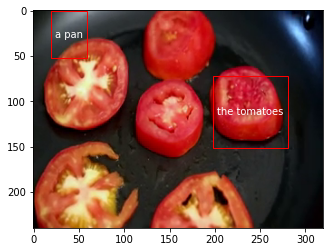

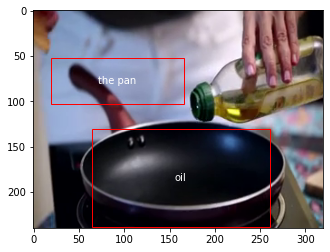

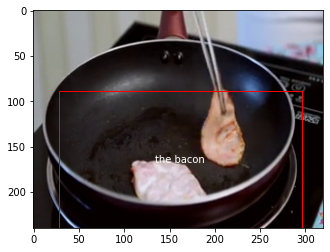

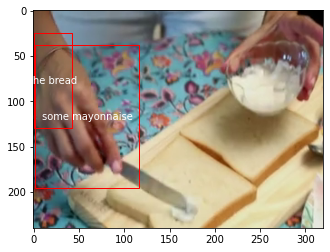

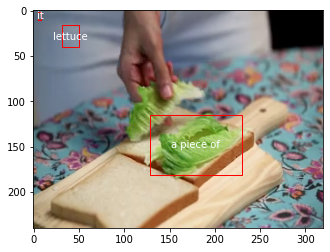

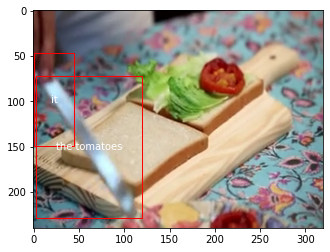

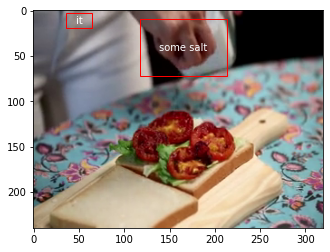

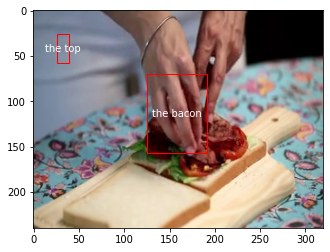

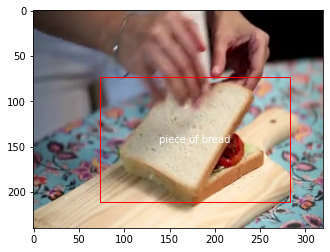

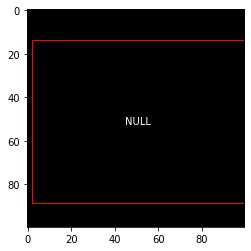

In [108]:
visualize(VG, RR, bb, entities, entity_count, steps, directory)

In [17]:
def train(model, epochs=25, lr=0.001, batch_size=10, y=0.5):
    '''
    Training loop for the model.
    '''
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Ouput losses.
    train_loss = np.zeros(epochs)
    
    # Output accuracies.
    train_accuracy = np.zeros(epochs)
    
    m_RR = None
    m_VG = None
    
    model.train()
    
    for epoch in range(epochs):
        # Zero out any gradients.
        optimizer.zero_grad()

        # Run inference (forward pass).
        loss_E, loss_V, loss_R = model(265, 2, 10, 5, steps, features, boxes, ENTITIES_COUNT)

        # Loss from alignment.
        loss_ = loss.loss_RA_MIL(y, loss_R, loss_E, loss_V)
        print(loss_)

        # Backpropagation (backward pass).
        loss_.backward()

        # Update parameters.
        optimizer.step()

        #m_RR = RR
        #m_VG = VG
            
        # TODO: save loss and accuracy at each epoch, plot (and checkpoint).
        train_loss[epoch] = loss_
        
    return train_loss

In [ ]:
model = Model()
train_loss = train(model, epochs=50, lr=0.0001)

tensor(397.5083, grad_fn=<SumBackward0>)
tensor(3777.6223, grad_fn=<SumBackward0>)
tensor(1839.2795, grad_fn=<SumBackward0>)
tensor(1486.8861, grad_fn=<SumBackward0>)
tensor(1778.6123, grad_fn=<SumBackward0>)
tensor(1102.3772, grad_fn=<SumBackward0>)
tensor(1398.0608, grad_fn=<SumBackward0>)


In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_loss)

In [25]:
model

Model(
  (lxmert): LxmertModel(
    (embeddings): LxmertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768, padding_idx=0)
      (token_type_embeddings): Embedding(2, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LxmertEncoder(
      (visn_fc): LxmertVisualFeatureEncoder(
        (visn_fc): Linear(in_features=2048, out_features=768, bias=True)
        (visn_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (box_fc): Linear(in_features=4, out_features=768, bias=True)
        (box_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (layer): ModuleList(
        (0): LxmertLayer(
          (attention): LxmertSelfAttentionLayer(
            (self): LxmertAttention(
              (query): Linear(in_features=

In [33]:
boxes.size()

torch.Size([2, 50, 4])

In [26]:
steps[0]

'grill [unused3] the tomatoes in [unused3] a pan. [SEP] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] add [unused3] oil into [unused3] the pan. [SEP] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] cook [unused3] the bacon. [SEP] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] spread [unused3] some mayonnaise onto [unused3] the bread. [SEP] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2] [unused2]

In [46]:
model = Model()
loss_E, loss_V, loss_R = model(265, 2, 10, 5, steps, features, boxes, ENTITIES_COUNT)

In [98]:
torch.tensor(loss_R)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 1., 1., 1., 1., 1., 1., 1., 1., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 1., 1., 1., 1.,

In [58]:
features.size()

torch.Size([2, 50, 2048])

In [ ]:
 MAX_INSTRUCTION_LENGTH, BATCH_SIZE, NUM_ACTIONS, CANDIDATES, steps, features, boxes, entity_count):
        '''
            MAX_INSTRUCTION_LENGTH
                : maximum number of words in a combined string of steps for a video,
                  this instruction string must contain the NULL step.
                  
                  ex. | E ... E . [SEP] [PAD] [PAD] | .... [SEP] [PAD] | NULL | 
                  
            steps
                : batched video steps of size (BATCH_SIZE, NUM_ACTIONS), list of lists,
                  each instructional video must have the same number of steps = NUM_ACTIONS.
                
                  ex. [['step 1.1', 'step 1.2'], ['step 2.1', 'step 2.2']]
                
            features
                : batched detection features of size (BATCH_SIZE, CANDIDATES * NUM_ACTIONS, 2048)
                
            boxes
                : batched bounding boxes of detection features of size (BATCH_SIZE, CANDIDATES * NUM_ACTIONS, 4)
                
            entity_count:
                : number of entities per action, size (BATCH_SIZE, NUM_ACTIONS), list of lists
        '''

In [19]:
        inputs = tokenizer(
            steps,
            padding="max_length",
            max_length= 265 + 2, # [CLS] and [SEP] token
            truncation=False,
            return_token_type_ids=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )

In [18]:
len(steps[1].split(' '))

265

In [27]:
inputs['input_ids']

tensor([[  101, 18651,     4,  1996, 12851,  1999,     4,  1037,  6090,  1012,
           102,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,  5587,     4,  3514,  2046,     4,  1996,  6090,  1012,
           102,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,  5660,     4,  1996, 11611,  1012,   102,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,  3659,     4,  2070, 14415,  9516,  5562,
          3031,     4,  1996,  7852,  1012,   102,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,  2173,  

In [30]:
decoded_steps = tokenizer.batch_decode(inputs['input_ids'])

In [32]:
len(decoded_steps[0].split(' '))

267

In [21]:
lxmert = LxmertModel.from_pretrained("unc-nlp/lxmert-base-uncased")

In [22]:
        output = lxmert(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask,
            visual_feats=features,
            visual_pos=boxes,
            token_type_ids=inputs.token_type_ids,
            return_dict=True,
            output_attentions=True
        )

In [25]:
output['language_output'].size()

torch.Size([2, 282, 768])

In [39]:
NUM_ACTIONS=10
BATCH_SIZE=2

edge_mask = torch.ones(NUM_ACTIONS, NUM_ACTIONS).tril(diagonal=-1)
edge_mask[-1, :] = 0
edge_mask[:, -1] = 1
edge_mask = einops.repeat(edge_mask, 'x y -> b x c y', b=BATCH_SIZE, c=5)

In [41]:
edge_mask[0]

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

        [[1., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 1.]],

        [[1., 1., 1., 0., 0., 0., 0., 0., 0., 1.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 1.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 1.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 1.],
         [1., 1., 1., 0.,

In [53]:
a = torch.rand(2,10, 10)

In [54]:
a.diagonal(dim1 = 1, dim2= 2).size()

torch.Size([2, 10])